### ДЗ_3. «Модели ARMA»

## Задание

- Выберите ряд из первого задания.
- Постройте его модель ARIMA.
- Оформите отчёт в Jupyter-ноутбук.

## Дополнительное задание *

Попробуйте спрогнозировать график классическим ML.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
# import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## ARIMA (p,d,q) (из лекции)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные\
ряды не стационарны, но они могут такими стать в результате операции дифференцирования. \
В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель

In [8]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [9]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## Решение:

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


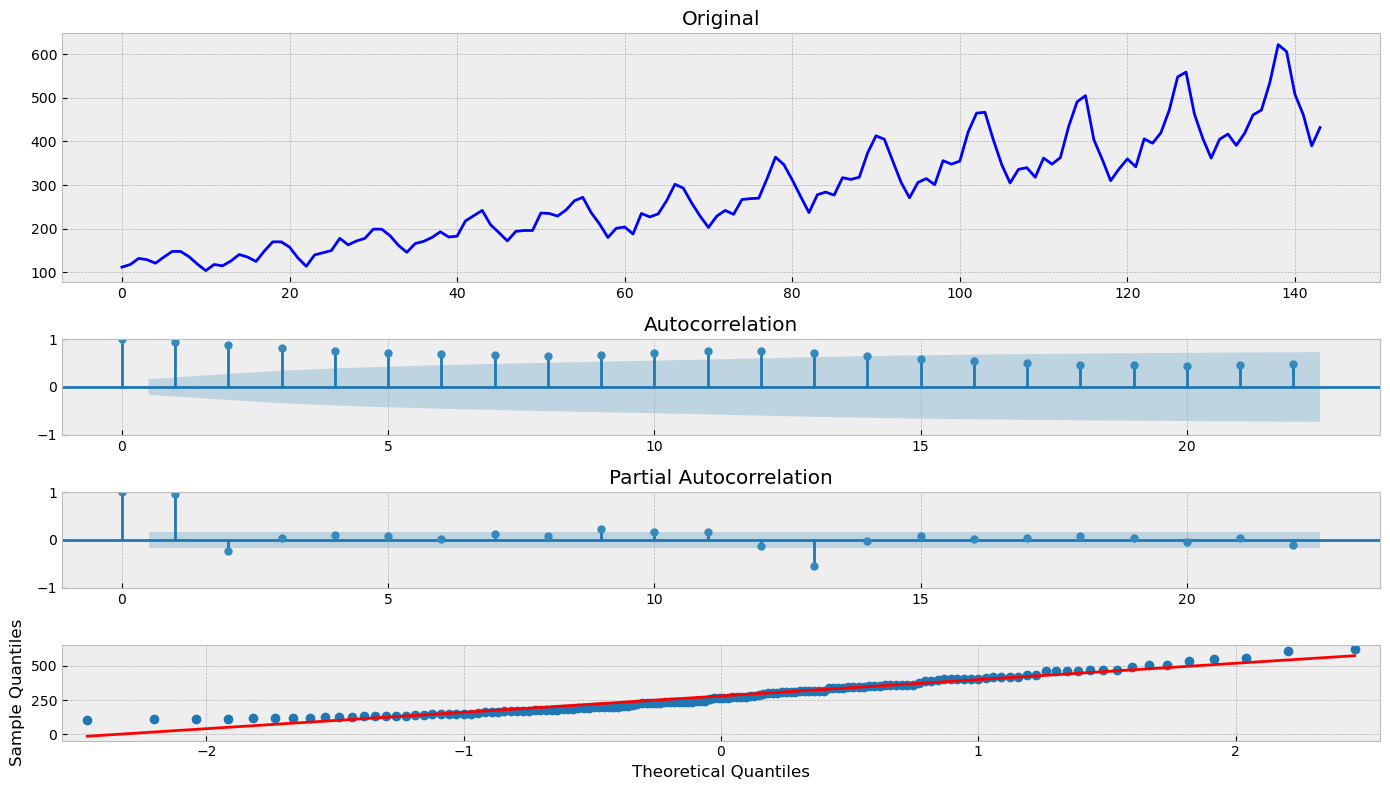

In [10]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
# series = series.astype('float64')
tsplot(series)

### Модель ARIMA

>***Комментарий к решению проблемы:***
>
> Из лекции пытался взять statsmodule, но так как он там был версии 0.12.0, т.е. старой, \
> то у меня не получалось решение. У меня установлен - версия 14\
> после немкольких попыток установить верисию 12, возникали ошибки взаимосвязанные с этим модулем, \
> т.е. надо было бы полностью переустановить все и скатиться до Python 2-х летнйе давности \
> *(это решение я нашел в интернете, что меня совсем не устраивало, так как часть моей работы я \
> делаю с использованием новых версии python*
> 
> В итоге после нескольких дней изучения нового модуля получил следующие результаты работы:

In [11]:
warnings.filterwarnings("ignore")

In [12]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = ARIMA(TS, order=(i,d,j)).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



In [13]:
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [14]:
aic, order, mdl = _get_best_model(series)

aic: -450.22992 | order: (2, 0, 1)


Results of Dickey-Fuller Test:
Test Statistic                  -4.247216
p-value                          0.000548
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


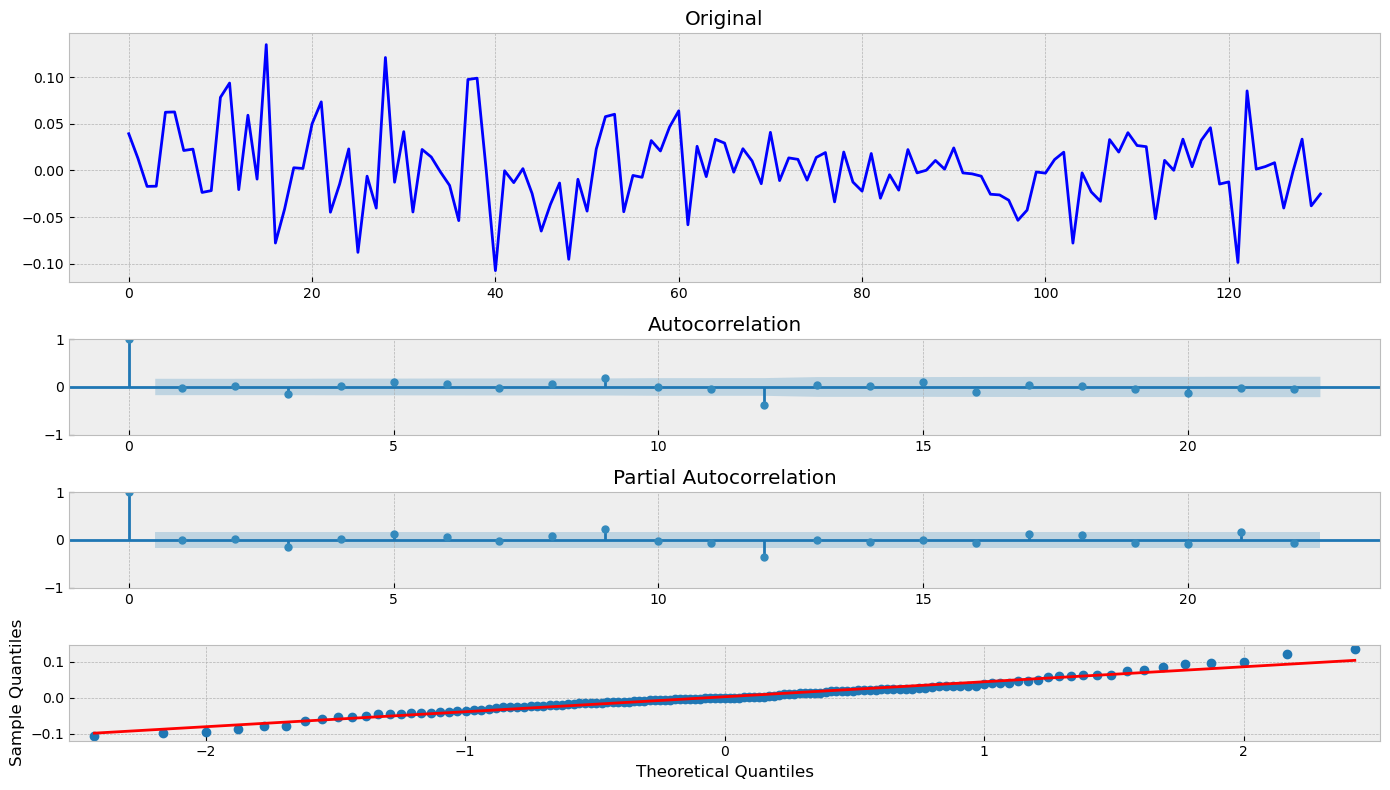

In [15]:
tsplot(mdl.resid)

In [16]:
train = series[:int(len(series)*0.6)]
test = series[int(len(series)*0.6):]

In [17]:
model = ARIMA(train, order=order)
model_fit = model.fit()

In [18]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [19]:
mse = mean_squared_error(test, predictions)
print(f'Test MSE: {mse:.3f}')

Test MSE: 0.001


In [20]:
forecast = model_fit.forecast(steps=30)

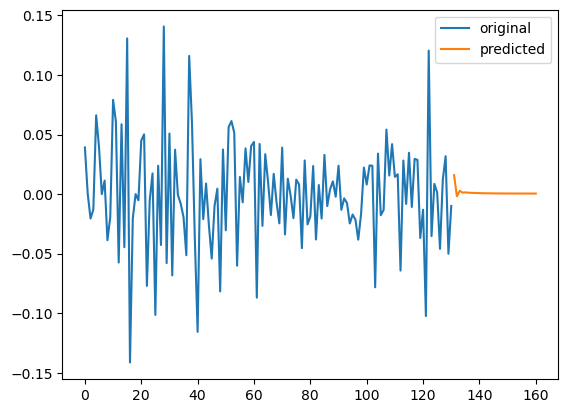

In [21]:
plt.plot(series, label='original')
plt.plot(pd.RangeIndex(start=len(series), stop=len(series)+len(forecast)), forecast, label='predicted')
plt.legend()
plt.show()